# Urbansed

In [148]:
# Automatically reload modules before entering the execution of code typed at 
# the IPython prompt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
# Import used libraries
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import librosa
import torch

torch.manual_seed(0)

print(f"{pd.__name__} version: {pd.__version__}")
print(f"{matplotlib.__name__} version: {matplotlib.__version__}")
print(f"{librosa.__name__} version: {librosa.__version__}")
print(f"{torch.__name__} version: {torch.__version__}")

pandas version: 2.1.2
matplotlib version: 3.8.3
librosa version: 0.10.2.post1
torch version: 2.4.0


In [150]:
from yoho.utils import AudioFile

def plot_melspectrogram(
    audio: AudioFile,
    n_mels: int = 40,
    win_len: float = 0.04,
    hop_len: float = 0.01,
):
    """
    Plots the Mel spectrogram.
    """
    plt.figure(figsize=(10, 4))
    plt.title(f"Mel spectrogram")
    librosa.display.specshow(
        data=audio.mel_spectrogram(
            n_mels=n_mels, win_len=win_len, hop_len=hop_len
        ),
        sr=audio.sr,
        hop_length=hop_len*audio.sr,
        x_axis="s",
        y_axis="mel",
    )
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

## TUT Dataset

In [151]:
from yoho.train import load_dataset
from yoho.utils import UrbanSEDDataset

urbansed_train: UrbanSEDDataset = load_dataset(partition="train")
urbansed_val: UrbanSEDDataset = load_dataset(partition="validate")

print(f"Number of audio clips in the train dataset: {len(urbansed_train)}")
print(f"Number of audio clips in the validation dataset: {len(urbansed_val)}")
print(f"Duration of each audio clips: {urbansed_train.audios[0].duration} seconds")
print(f"Sampling rate of each audio clips: {urbansed_train.audios[0].sr} Hz")

INFO:root:Loading the train dataset from the pickle file


INFO:root:Loading the validation dataset from the pickle file


Number of audio clips in the train dataset: 54000
Number of audio clips in the validation dataset: 18000
Duration of each audio clips: 2.56 seconds
Sampling rate of each audio clips: 44100 Hz


## Data generator

In [152]:
from yoho.utils import YOHODataGenerator

val_dataloader = YOHODataGenerator(
    urbansed_val, batch_size=32, shuffle=True
)

val_features, val_labels = next(iter(val_dataloader))

print(f"Test features shape: {val_features.shape}")
print(f"Test labels shape: {val_labels.shape}")

Test features shape: torch.Size([32, 1, 40, 257])
Test labels shape: torch.Size([32, 33, 9])


## YOHO model

In [153]:
from torchsummary import summary

from yoho.models import YOHO
from yoho.train import get_device

# Get the available device (cuda, mps or cpu)
device = get_device()

# Define the model
urbansed_model = YOHO(
    name="UrbanSEDYOHO",
    input_shape=(1, 40, 257), n_classes=len(urbansed_train.labels)
).to(device)

urbansed_model.load(f"./models/{urbansed_model.name}_checkpoint.pth.tar", device)

summary(
    urbansed_model,
    input_size=(1, 40, 257),
    batch_size=32,
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [32, 32, 20, 129]             288
       BatchNorm2d-2          [32, 32, 20, 129]              64
              ReLU-3          [32, 32, 20, 129]               0
            Conv2d-4          [32, 32, 20, 129]             288
       BatchNorm2d-5          [32, 32, 20, 129]              64
              ReLU-6          [32, 32, 20, 129]               0
            Conv2d-7          [32, 64, 20, 129]           2,112
       BatchNorm2d-8          [32, 64, 20, 129]             128
              ReLU-9          [32, 64, 20, 129]               0
        Dropout2d-10          [32, 64, 20, 129]               0
DepthwiseSeparableConv-11          [32, 64, 20, 129]               0
           Conv2d-12           [32, 64, 10, 65]             576
      BatchNorm2d-13           [32, 64, 10, 65]             128
             ReLU-14           [32

## Evaluation

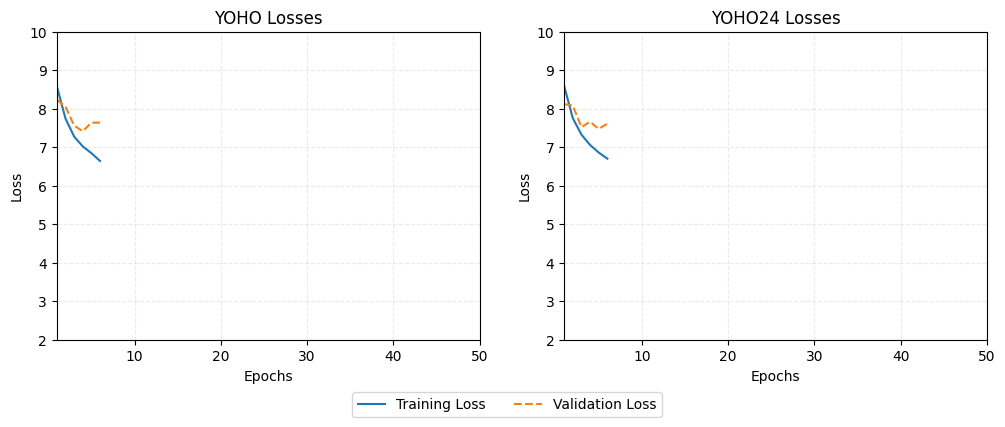

In [163]:
import json
import matplotlib.pyplot as plt

# Path to the losses.json file:

# Load the losses.json file
with open("./models/UrbanSEDYOHO_losses.json", "r") as f:
    losses = json.load(f)

# Extract epochs, train_loss, and val_loss
epochs = []
train_losses = []
val_losses = []

for epoch, metrics in losses.items():
    epochs.append(int(epoch))
    train_losses.append(metrics["train_loss"])
    val_losses.append(metrics["val_loss"])

# Sort the data by epochs to ensure correct plotting
epochs, train_losses, val_losses = zip(
    *sorted(zip(epochs, train_losses, val_losses))
)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title("YOHO Losses")
ax[0].plot(epochs, train_losses, label="Training Loss")
ax[0].plot(epochs, val_losses, label="Validation Loss", linestyle="--")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_xlim(1,50)
ax[0].set_ylim(2,10)
ax[0].grid(alpha=.25, linestyle='--')

with open("./models/UrbanSEDYOHO24_losses.json", "r") as f:
    losses = json.load(f)

# Extract epochs, train_loss, and val_loss
epochs = []
train_losses = []
val_losses = []

for epoch, metrics in losses.items():
    epochs.append(int(epoch))
    train_losses.append(metrics["train_loss"])
    val_losses.append(metrics["val_loss"])

# Sort the data by epochs to ensure correct plotting
epochs, train_losses, val_losses = zip(
    *sorted(zip(epochs, train_losses, val_losses))
)

ax[1].set_title("YOHO24 Losses")
ax[1].plot(epochs, train_losses, label="Training Loss")
ax[1].plot(epochs, val_losses, label="Validation Loss", linestyle="--")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_xlim(1,50)
ax[1].set_ylim(2,10)
ax[1].grid(alpha=.25, linestyle='--')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5,-0.1))

plt.show()

In [166]:
predictions = urbansed_model(val_features.to(device))
targets = val_labels.to(device)

In [168]:
import numpy as np

labels_ = [
    "noise",
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music",
]


def process_output(output: np.array) -> list[tuple[str, float, float]]:

    STEPS_NO = 9
    step_duration = 2.56 / STEPS_NO
    MIN_EVENT_DURATION = 0
    MIN_SILENCE_DURATION = 1.0

    processed_output = []

    for k in range(output.shape[0]):

        labels = []
        for i in range(output.shape[2]):

            for j in range(0, output.shape[1], 3):
                if output[k, j, i] >= 0.5:
                    label = labels_[j // 3]
                    start = (
                        i * step_duration + output[k, j + 1, i].item() * step_duration
                    )
                    end = (
                        i * step_duration + output[k, j + 2, i].item() * step_duration
                    )
                    labels.append((label, round(start, 2), round(end, 2)))

        # Order the labels by class
        labels = sorted(labels, key=lambda x: x[0])

        # Merge events of the same class that are close to each other
        merged_labels = []
        for label, start, end in labels:
            if not merged_labels:
                merged_labels.append((label, start, end))
            else:
                prev_label, prev_start, prev_end = merged_labels[-1]
                if prev_label == label and start - prev_end < MIN_SILENCE_DURATION:
                    merged_labels[-1] = (label, prev_start, end)
                else:
                    merged_labels.append((label, start, end))

        # Remove events that are too short
        merged_labels = [
            (label, start, end)
            for label, start, end in merged_labels
            if end - start >= MIN_EVENT_DURATION
        ]

        # Order the labels by start time
        # If two events start at the same time, order by class index
        merged_labels = sorted(
            merged_labels, key=lambda x: (x[1], labels_.index(x[0]))
        )

        processed_output.append(merged_labels)

    return processed_output


print(process_output(targets), process_output(predictions), sep="\n")

[[('noise', 0.0, 2.56), ('car_horn', 0.0, 0.47), ('air_conditioner', 0.1, 0.73)], [('noise', 0.0, 2.56), ('engine_idling', 0.0, 2.56), ('siren', 0.0, 0.92), ('drilling', 0.53, 2.28), ('street_music', 0.82, 2.56)], [('noise', 0.0, 2.0)], [('noise', 0.0, 2.56), ('gun_shot', 0.0, 1.6), ('car_horn', 0.03, 0.6), ('drilling', 0.49, 1.25), ('dog_bark', 1.09, 2.56), ('children_playing', 1.68, 2.56), ('car_horn', 2.19, 2.56)], [('noise', 0.0, 2.56), ('gun_shot', 0.0, 2.56), ('dog_bark', 0.76, 1.56), ('street_music', 2.25, 2.56)], [('noise', 0.0, 2.56), ('siren', 0.29, 1.28), ('dog_bark', 0.57, 2.56), ('engine_idling', 1.97, 2.49)], [('noise', 0.0, 2.56), ('air_conditioner', 0.0, 0.21), ('dog_bark', 0.0, 2.56), ('street_music', 0.0, 1.31), ('jackhammer', 1.69, 2.56)], [('noise', 0.0, 2.56)], [('noise', 0.0, 2.56), ('dog_bark', 0.0, 0.51), ('jackhammer', 0.03, 2.56)], [('noise', 0.0, 2.56), ('car_horn', 0.0, 0.33), ('dog_bark', 0.0, 2.28), ('siren', 0.0, 0.28)], [('noise', 0.0, 2.56)], [('noise',

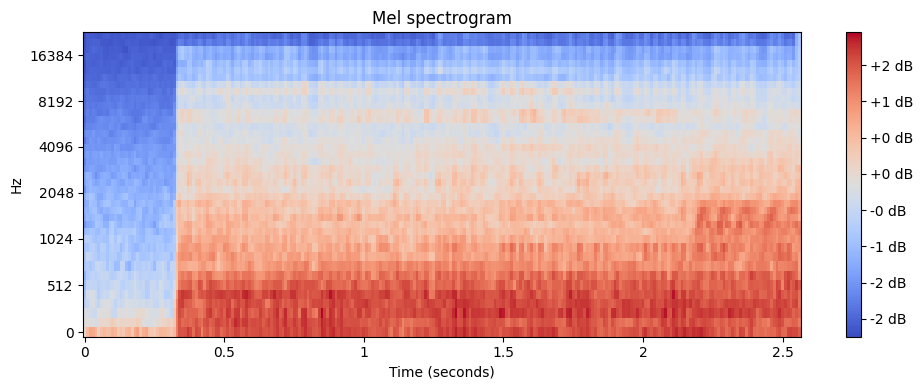

In [170]:
plot_melspectrogram(urbansed_val.audios[41])

In [158]:
import os

def get_test_set():
    urbansed_test = UrbanSEDDataset(
                audios=[
                    audioclip
                    for _, audio in enumerate(
                        AudioFile(
                            filepath=file.filepath, labels=eval(file.events)
                        )
                        for _, file in pd.read_csv(
                            "./data/raw/URBAN-SED/test.csv"
                        ).iterrows()
                    )
                    for audioclip in audio.subdivide(
                        win_len=2.56, hop_len=1.00
                    )
                ]
            )
    return urbansed_test

urbansed_test = get_test_set()

In [159]:
urbansed_test_dataloader = YOHODataGenerator(
    urbansed_test, batch_size=1, shuffle=False
)

In [160]:
import sed_eval
import dcase_util

labels_ = [
    "noise",
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music",
]

all_thruth_data = dcase_util.containers.MetaDataContainer()
all_predictions = dcase_util.containers.MetaDataContainer()


for idx, (features, _) in enumerate(urbansed_test_dataloader):

    # Get model predictions
    prediction = urbansed_model(features.to(device))
    labels = process_output(prediction[0])

    thruth = urbansed_test.audios[idx].labels
    print(f"Truth for audio clip {idx}: {thruth}")
    print(f"Prediction for audio clip {idx}: {labels}")

    all_thruth_data += dcase_util.containers.MetaDataContainer(
        [
            {
                "filename": f"{idx}.wav",
                "onset": onset,
                "offset": offset,
                "event_label": label,
            }
            for label, onset, offset in labels
        ]
    )

    all_predictions = dcase_util.containers.MetaDataContainer(
        [
            {
                "filename": f"{idx}.wav",
                "onset": onset,
                "offset": offset,
                "event_label": label,
            }
            for label, onset, offset in thruth
        ]
    )

    break


segment_based_metrics = sed_eval.sound_event.SegmentBasedMetrics(
    event_label_list=labels_,
    time_resolution=1.0,
)

# Evaluate the predictions
segment_based_metrics.evaluate(all_predictions, all_thruth_data)

overall_segment_based_metrics = segment_based_metrics.results_overall_metrics()
curr_f1 = overall_segment_based_metrics['f_measure']['f_measure']
curr_error = overall_segment_based_metrics['error_rate']['error_rate']

print("F1: {:.3f}, Error: {:.3f}".format(curr_f1, curr_error))

Truth for audio clip 0: [('noise', 0, 2.56), ('siren', 1.896800669134819, 2.56)]
Prediction for audio clip 0: [('noise', 0.0, 2.56), ('siren', 2.28, 2.55)]
F1: 0.889, Error: 0.200
